# Predicting Used Car Prices by Building ML Model from Scratch
In this project we will use the second hand car prediction dataset from Kaggle to  predict the price of a car based on its specifications, by implementing a linear/polynomial regression model from scratch. This includes:
- Defining the model
- Defining the loss/cost function
- Implementing Back propogation
- Feature Selection
- Feature Normalization
- Applying regularization

### Reading Data
- First save the csv file from Kaggle
- Import the required libraries
- Read the data into a df

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# save the file path for easier access
cars_file_path = 'cars.csv'
# read the data and store in a DataFrame named cars_df
df_cars = pd.read_csv(cars_file_path, index_col=0)
# head of the data
df_cars.head()

,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
Car_ID,,,,,,,,,,,,
1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5,800000
2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5,1000000
3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4,2500000
4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5,600000
5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5,850000


In [106]:
# Changing the display format for numeric values
# pd.options.display.float_format = "{:,.3f}".format

### Data Analysis - I
Analysing the components of the data so that we can determine how to convert it

Shape of Data i.e. number of rows and columns

In [107]:
# Number of Records in data
df_cars.shape

(100, 12)

**Datatypes** of df. 
We want to use numeric data

In [108]:
# see the datatypes of the df
df_cars.dtypes

Brand                object
Model                object
Year                  int64
Kilometers_Driven     int64
Fuel_Type            object
Transmission         object
Owner_Type           object
Mileage               int64
Engine                int64
Power                 int64
Seats                 int64
Price                 int64
dtype: object

**Null Values** : check the number of null values in each column

In [109]:
df_cars.isnull().sum()

Brand                0
Model                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [110]:
stats = ['max', 'min', 'mean', 'std','count']
df_cars.describe().loc[stats]

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
max,"2,021.00","60,000.00",25.00,"4,951.00",396.00,7.00,"4,000,000.00"
min,"2,016.00","10,000.00",10.00,999.00,68.00,4.00,"450,000.00"
mean,"2,018.39","28,150.00",17.21,"1,855.23",158.13,5.23,"1,574,000.00"
std,1.17,"9,121.38",3.31,631.31,76.97,0.75,"1,000,264.61"
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00


**Owner_Type**: Check the number of unique values of owner_types and the count of each. We will convert this into numeric data later

In [111]:
# Owner_Type and the corresponding number of times it appears
# df_cars.groupby('Owner_Type').Owner_Type.count()
df_cars.Owner_Type.value_counts()

Owner_Type
First     44
Second    43
Third     13
Name: count, dtype: int64

**Brand**: Decide how to convert this to numeric data or to drop the feature

In [112]:
df_cars.Brand.value_counts()

Brand
Ford          11
Hyundai       11
Tata          11
Toyota        10
Volkswagen    10
Audi          10
BMW           10
Mercedes      10
Honda          6
Maruti         6
Mahindra       5
Name: count, dtype: int64

In [113]:
df_cars.Brand.nunique()

11

**Model** : If there are too many models, we will drop it as there are only 100 rows of data. 
FurtherMore there is a different model for different brands, and during training we will not be coupling them, hence without the realtionship there is no meaningful insights bw the two

In [114]:
if df_cars.Model.nunique()>15:
    df_cars = df_cars.drop(columns="Model")

### Data Pre-Processing
Convert the data to be usable by the ML Models

In [115]:
# Will allow you to run cells multile times without having to restart kernel as the data will be modified in a new df
df_cars_clean = df_cars.copy()

##### Encoding Brands


We know there are 11 unique brands, we have a choice between three options:
1. Dropping the column
2. Ordinal Encoding
3. One-Hot Encoding
- Since we don't know the model of the car (since we dropped the column), a car of the same brand may differ drastically in price. However the price of the car still will have some dependancy on the brand which is independant from the price -> hence we can't drop the column
-  We don't have an indistputable ranking to the brands hence we cannot use ordinal encoding
- Hence **we use One-Hot encoding**

<small> We also do this step first, since the Pandas function pd.get_dummies() will use the orginal dataframe, (we could use the copy data, but then we would not be able to run the cell twice). And if we keep this step after encoding other columns, the previous encodings will be lost as we are using original dataframe
(This could be mitigated by usings sci-kit learns One-Hot Encoder, but I am trying to use as little of sci-kit's built in functions) </small>

In [116]:
df_cars.value_counts('Brand')

Brand
Ford          11
Hyundai       11
Tata          11
Audi          10
BMW           10
Mercedes      10
Toyota        10
Volkswagen    10
Honda          6
Maruti         6
Mahindra       5
Name: count, dtype: int64

In [117]:
# Implementing one-hot encoding using Pandas
df_cars_clean = pd.get_dummies(df_cars, columns = ['Brand'], dtype=int)


##### Encoding Owner_Type


There is a clear ranking in owner_types, hence we can use **ordinal encoding**

In [118]:
def owner_type(data):
    if(data == "First"):
        return 1
    elif(data == "Second"):
        return 2
    elif(data == "Third"):
        return 3

df_cars_clean['Owner_Type'] = df_cars.Owner_Type.apply(owner_type)

In [119]:
df_cars_clean.Owner_Type.value_counts()

Owner_Type
1    44
2    43
3    13
Name: count, dtype: int64

##### Encoding Fuel_Type and Transmission

We will do **One-Hot Boolean encoding** for the Fuel_Type and Transmission Features by:
- 0 for petrol and 1 for diesel 
- 0 for manual and 1 for automatic

In [120]:
def fuel_type(data):
    if(data == "Petrol"):
        return 0
    elif(data == "Diesel"):
        return 1

df_cars_clean['Fuel_Type'] = df_cars.Fuel_Type.apply(fuel_type)

In [121]:
def transmission_type(data):
    if(str("Manual") in data):
        return 0
    elif(str("Automatic") in data):
        return 1

df_cars_clean['Transmission'] = df_cars.Transmission.apply(transmission_type)

##### Converting Year from Year Bought to Years Old

In [122]:
df_cars_clean["Year"] = df_cars_clean.Year.map(lambda y: 2024-y)

##### Final Pre-Processed Data

In [123]:
df_cars_clean.describe().loc[stats]

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,...,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Mahindra,Brand_Maruti,Brand_Mercedes,Brand_Tata,Brand_Toyota,Brand_Volkswagen
max,8.00,"60,000.00",1.00,1.00,3.00,25.00,"4,951.00",396.00,7.00,"4,000,000.00",...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,3.00,"10,000.00",0.00,0.00,1.00,10.00,999.00,68.00,4.00,"450,000.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mean,5.61,"28,150.00",0.48,0.57,1.69,17.21,"1,855.23",158.13,5.23,"1,574,000.00",...,0.10,0.11,0.06,0.11,0.05,0.06,0.10,0.11,0.10,0.10
std,1.17,"9,121.38",0.50,0.50,0.69,3.31,631.31,76.97,0.75,"1,000,264.61",...,0.30,0.31,0.24,0.31,0.22,0.24,0.30,0.31,0.30,0.30
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [124]:
df_cars_clean.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,...,Brand_BMW,Brand_Ford,Brand_Honda,Brand_Hyundai,Brand_Mahindra,Brand_Maruti,Brand_Mercedes,Brand_Tata,Brand_Toyota,Brand_Volkswagen
Car_ID,,,,,,,,,,,,,,,,,,,,,
1,6,50000,0,0,1,15,1498,108,5,800000,...,0,0,0,0,0,0,0,0,1,0
2,5,40000,0,1,2,17,1597,140,5,1000000,...,0,0,1,0,0,0,0,0,0,0
3,7,20000,0,1,1,10,4951,395,4,2500000,...,0,1,0,0,0,0,0,0,0,0
4,4,30000,1,0,3,23,1248,74,5,600000,...,0,0,0,0,0,1,0,0,0,0
5,8,60000,1,1,2,18,1999,194,5,850000,...,0,0,0,1,0,0,0,0,0,0


In [125]:
df_cars_clean.dtypes

Year                 int64
Kilometers_Driven    int64
Fuel_Type            int64
Transmission         int64
Owner_Type           int64
Mileage              int64
Engine               int64
Power                int64
Seats                int64
Price                int64
Brand_Audi           int64
Brand_BMW            int64
Brand_Ford           int64
Brand_Honda          int64
Brand_Hyundai        int64
Brand_Mahindra       int64
Brand_Maruti         int64
Brand_Mercedes       int64
Brand_Tata           int64
Brand_Toyota         int64
Brand_Volkswagen     int64
dtype: object

## Building the Model

### Feature Selection

Let's view the dataset and its features by plotting each feature versus price.

In [126]:
y = df_cars_clean.Price 
X_raw = df_cars_clean.loc[:,df_cars_clean.columns != "Price"]

In [127]:
X_raw.head()
print(X_raw.columns.size)

20


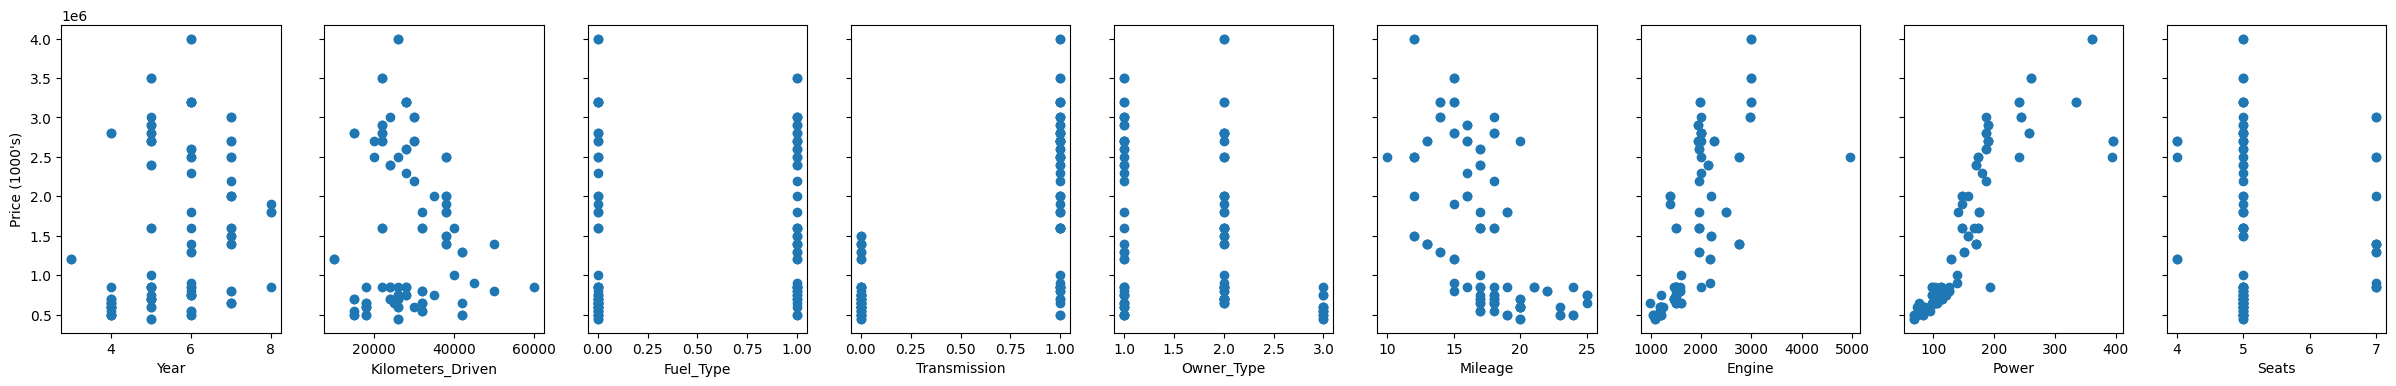

In [128]:
fig,ax=plt.subplots(1, 9, figsize=(30, 4), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_raw.iloc[:,i],y)
    ax[i].set_xlabel(X_raw.columns[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Plotting each feature vs. the target, price, provides some indication of which features have the strongest influence on price. We can infer the following from the above plots:
1. **Year** - The datapoints don't show any strong relationship, however this could be due to less number of data points as well as stronger influence of other factors - **DROP**
2. **Kilometers_Driven** : Although we know there is a negative correlation bw the km_driven and price, there are many datapoints which have both lows and high prices at tge same distance driven. This may skew the prediction in the wrong way.  Therefore plot the predicted values and then decide whether to Keep or Drop - **KEEP** 
3. **Fuel_Type** : Not much correlation with price - **DROP**
4. **Transmission** : There is a correlation, as this is a boolean feature and we see manual (transmission=0) vehicles seemingly going for less price - **KEEP**
5. **Owner_Type** : Negative Correlation - **KEEP**
6. **Mileage** : Negative Correlation - **KEEP**
7. **Engine** : Positive Correltion - **KEEP**
8. **Power** : Positive Correltion - **KEEP**
9. **Seats** : No Correlation - **DROP**

In [129]:
# selected_features = ['Kilometers_Driven', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power']
# selected_features = ['Power']
selected_features = ['Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power']
X = X_raw[selected_features]
y = y

### Defining the Models Prediction Function

The linear regression model's prediction (for one training example) with multiple variables is given by the model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  \hat{y} = w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b$$

or in **vector notation** for $n$ features and $m$ training examples:

$$  
\begin{pmatrix}
{x_0}^{(0)} ~~ {x_1}^{(0)} \dots {x_n}^{(0)} \\
{x_0}^{(1)} ~~ {x_1}^{(1)} \dots {x_n}^{(1)} \\
\vdots \\
{x_0}^{(m)} ~~ {x_1}^{(m)} \dots {x_n}^{(m)} \\
\end{pmatrix}_{m \times n}
\bullet
~~~
\begin{pmatrix} w_0 \\ w_1 \\ \vdots \\ w_n \end{pmatrix}_{n \times 1}
= ~~~ \begin{pmatrix} \hat{y}^{(0)} \\ 
\hat{y}^{(1)} \\ 
\vdots \\ \hat{y}^{(m)} \end{pmatrix}_{m \times 1}  $$ 

### Feature Engineering

In [130]:
X.head()

,Transmission,Owner_Type,Mileage,Engine,Power
Car_ID,,,,,
1,0,1,15,1498,108
2,1,2,17,1597,140
3,1,1,10,4951,395
4,0,3,23,1248,74
5,1,2,18,1999,194


In [131]:
X_e = pd.concat([X, X**2, X**3], axis=1)
# X_engineered.columns.values[1] = "Power^2"
# X_engineered.columns.values[2] = "Power^3"
X_e.head()

,Transmission,Owner_Type,Mileage,Engine,Power,Transmission,Owner_Type,Mileage,Engine,Power,Transmission,Owner_Type,Mileage,Engine,Power
Car_ID,,,,,,,,,,,,,,,
1,0,1,15,1498,108,0,1,225,2244004,11664,0,1,3375,3361517992,1259712
2,1,2,17,1597,140,1,4,289,2550409,19600,1,8,4913,4073003173,2744000
3,1,1,10,4951,395,1,1,100,24512401,156025,1,1,1000,121360897351,61629875
4,0,3,23,1248,74,0,9,529,1557504,5476,0,27,12167,1943764992,405224
5,1,2,18,1999,194,1,4,324,3996001,37636,1,8,5832,7988005999,7301384


In [132]:
X_e.shape

(100, 15)

### Feature Scaling

##### Requirement

Feature Scaling is important so that the features have a similar range of values. The reason it is necessary for features to have similar values is to speed up the process of backpropogation. <br>
The intuition behind this is as follows: <br>  Imagine that there are two features $X_0$ and $X_1$. $X_0$ is scaled in the 10000s and $X_1$ scales in the single digits. 
Since we know that: 
$$
\hat{y} = f_{w,b}(X) =  W_0X_0 + W_1X_1 + b
$$
The value of $W_0$ will be very small as $X_0$ is large and a small change is $W_0$ will lead to a large change in $\hat{y}$. <br>
Conversely value of $W_1$ will be very large as $X_1$ is small and hence a large change is needed to change $\hat{y}$ <br>

Now the problem lies in choosing the learning rate <br>
1. If learning rate is too high then, $W_1$ will update in too large jumps leading to the cost function not being minimized due to **overshooting**, hence we will have to choose a smaller learning rate to ensure convergence  
2. Now with this smaller learning rate, we will achieve convergence, but the time taken to update the smaller parameter $W_1$ will take much longer than time taken by $W_0$ 

In [133]:
X.describe().loc[stats]

,Transmission,Owner_Type,Mileage,Engine,Power
max,1.00,3.00,25.00,"4,951.00",396.00
min,0.00,1.00,10.00,999.00,68.00
mean,0.57,1.69,17.21,"1,855.23",158.13
std,0.50,0.69,3.31,631.31,76.97
count,100.00,100.00,100.00,100.00,100.00


##### Z-Score Normalization

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 

>**Remember:** When normalizing the features, it is important to store the values used for normalization - the mean value and the standard deviation used for the computations. 
This is because we will use these to normalize the input values in X_validate as the weights (parameters) are calculated using normalized input variables, hence during prediction, the input variables must also be normalized

In [134]:
def zscore_normalize_features(X):
    """
    computes the zscore normalized X by column
    
    Args:
      X (df (m,n))     : input data, m examples, n features
      features (arrayLike (<n)) : List of features to be normalized

    Returns:
      X_norm (df (m,n)): input normalized by column
      mu (df (n,))     : mean of each feature
      sigma (df (n,))  : standard deviation of each feature
    """
    X_norm = X.copy()
    # find the mean for each feature
    mu = X.mean(axis=0)
    # find the standard deviation of each column/feature
    sigma = X.std(axis=0)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma 
    return (X_norm, mu, sigma)

In [135]:
def zscore_normalize_target(y):
    """
    computes the zscore normalized target variable y
    
    Args:
      y (df (m, ))     : target data, m examples Series

    Returns:
      y_norm (df (m,n)): target data normalized 
      mu (scalar)     : mean of target data
      sigma (scalar)  : standard deviation target data
    """
    y_norm = y.copy()
    # find the mean for target data
    mu = y.mean()
    # find the standard deviation of target data
    sigma = y.std()
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (y - mu) / sigma 
    return (X_norm, mu, sigma)

In [136]:
X_e.describe().loc[stats]

,Transmission,Owner_Type,Mileage,Engine,Power,Transmission,Owner_Type,Mileage,Engine,Power,Transmission,Owner_Type,Mileage,Engine,Power
max,1.00,3.00,25.00,"4,951.00",396.00,1.00,9.00,625.00,"24,512,401.00","156,816.00",1.00,27.00,"15,625.00","121,360,897,351.00","62,099,136.00"
min,0.00,1.00,10.00,999.00,68.00,0.00,1.00,100.00,"998,001.00","4,624.00",0.00,1.00,"1,000.00","997,002,999.00","314,432.00"
mean,0.57,1.69,17.21,"1,855.23",158.13,0.57,3.33,307.03,"3,836,446.99","30,869.95",0.57,7.39,"5,670.41","8,960,561,492.25","7,370,335.83"
std,0.50,0.69,3.31,631.31,76.97,0.50,2.61,118.81,"3,053,336.60","33,618.03",0.50,8.29,"3,342.98","13,490,523,441.87","13,010,649.74"
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [137]:
X_norm_test = zscore_normalize_features(X)
X_norm_test[0].describe().loc[stats]

,Transmission,Owner_Type,Mileage,Engine,Power
max,0.86,1.89,2.35,4.90,3.09
min,-1.15,-1.00,-2.18,-1.36,-1.17
mean,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
count,100.00,100.00,100.00,100.00,100.00


In [138]:
y.describe().loc[stats]

max     4,000,000.00
min       450,000.00
mean    1,574,000.00
std     1,000,264.61
count         100.00
Name: Price, dtype: float64

In [139]:
y_norm_test = zscore_normalize_target(y)
y_norm_test[0].describe().loc[stats]

max       2.43
min      -1.12
mean      0.00
std       1.00
count   100.00
Name: Price, dtype: float64

### Defining a Weights Matrix and Bias

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - n is the number of features, in our dataset, n is 20.

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ w_1 \\ w_2 \\ \dots  \\ w_n
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

In [140]:
# used for testing functions
w_init_test = pd.Series(0, index=range(0, X.shape[1]), dtype=float)
b_init_test = 0

### Defining the Cost/Loss Function

The equation for the **mean square cost function**  $J(\mathbf{w},b)$ is:
$$ J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 $$ 

We will calculate the cost function in 3 different ways to compare the speeds of matrix multiplication, vector dot product and looping

In [141]:
def calculate_cost_matrix(X, y, w, b):
    """
    compute cost for current weights using vector multiplication
        Args:
            X (df (m, n)) : Data, m training examples with n features \\
             y (df Shape (m,)) actual value
            w (df (n, )) : models weight parameters
            b (scalar) : models bias parameter
    """
    # To make the multiplication work, you'll have to convert at least one of the dataframes into a numpy array 
    m = X.shape[0]
    X = np.array(X)
    # calculate f_wb for all training examples
    f_wb = X @ w + b

    # calculate cost
    total_cost = (1/(2*m))*np.sum((f_wb-y)**2)
    return total_cost

In [142]:
def calculate_cost_vectors(X, y, w, b):
    """
    compute cost for current weights using vector multiplication
        Args:
            X (df (m, n)) : Data, m training examples with n features   
             y (df Shape (m,)) actual value
            w (df (n, )) : models weight parameters
            b (scalar) : models bias parameter
    """
    # To make the dot operation work, you'll have to convert at least one of the dataframes into a numpy array
    m = X.shape[0]
    X = np.array(X)
    # calculate f_wb for all training examples
    f_wb = X.dot(w) + b

    # calculate cost
    total_cost = (1/(2*m))*np.sum((f_wb-y)**2)
    return total_cost

In [143]:
def calculate_cost_loop(X, y, w, b):
    """
    compute cost for current weights using vector multiplication
        Args:
            X : (df (m, n)) | Data, m training examples with n features
             y : (df Shape (m,)) | actual value
            w : (df (n, )) | models weight parameters
            b : (scalar) | models bias parameter
    """
    m = X.shape[0]
    X = np.array(X)
    cost = 0.0
    for i in range(0,m):
        f_wb_i = np.dot(X[i],w) + b
        cost = cost + (f_wb_i - y.iloc[i])**2 

    cost = cost/(2*m)
    return np.squeeze(cost)

In [144]:
start = time.time()
c = calculate_cost_matrix(X, y, w_init_test, b_init_test)
end = time.time()
# print(f"cost in matrix =  {c:.4f}")
print(f"Matrix mul version duration: {1000*(end-start):.4f} ms ")

start = time.time()
c = calculate_cost_vectors(X, y, w_init_test, b_init_test)
end = time.time()
# print(f"cost in vector dot product =  {c:.4f}")
print(f"Vector dot product version duration: {1000*(end-start):.4f} ms ")

start = time.time()
c = calculate_cost_loop(X, y, w_init_test, b_init_test)
end = time.time()
# print(f"cost in loop =  {c:.4f}")
print(f"Loop version duration: {1000*(end-start):.4f} ms ")

Matrix mul version duration: 0.3481 ms 
Vector dot product version duration: 0.1512 ms 
Loop version duration: 1.4472 ms 


We can see there is a clear winner when it comes to speed of calculation, it goes from fastest to slowest as follows:
1. Vector dot product
2. Matrix Multiplication
3. Loop <br>

There are a few instances where matrix multiplication is faster than Vector dot product, but this occurs less than 5% of the time

### Defining Gradient Descent

The formula for gradient descent is:
$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$
Where $n$ is the number of features, and parameters $w_j, b$ are updated simultaneously

Using Vectors we can write the code as:
$$\begin{align*} \;  
& \vec{W} = \vec{W} -  \alpha \vec{d}  \newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}
\end{align*}$$

where d is a series (vector) containing the values of the partial derivatives

##### Batch Gradient Descent
- The values of the partial derivatives of a single training example is called its **Gradient**
- Because we are taking the average of the gradients of all $m$ training examples and then using that mean gradient to update our parameters, it is called ***Batch Gradient Descent***
$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} [(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}]   \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$
* m is the number of training examples in the data set

###### Using Matrix operations
![](gd_matrices.png)

In [145]:
def compute_gradient_vector(X, y, w, b):
    """
    Computes the gradient using matrix operations

    Args:
        X : (df (m, n)) | Data, m training examples with n features
        y : (df Shape (m,)) | actual value
        w : (df (n, )) | models weight parameters
        b : (scalar) | models bias parameter
    Returns
        dj_dw : (df (n,1)) | The gradient of the cost w.r.t. the parameters w. 
        dj_db : (scalar)   | The gradient of the cost w.r.t. the parameter b. 
    """
    
    m = X.shape[0]
    X = np.array(X)
    f_wb = X.dot(w) + b 
    e = f_wb - y
    dj_dw = 1/m * (X.T.dot(e))
    dj_db = 1/m * (np.sum(e))

    return dj_dw, dj_db

In [146]:
def compute_gradient_matrix(X, y, w, b):
    """
    Computes the gradient using matrix operations

    Args:
        X : (df (m, n)) | Data, m training examples with n features
        y : (df Shape (m,)) | actual value
        w : (df (n, )) | models weight parameters
        b : (scalar) | models bias parameter
    Returns
        dj_dw : (df (n,1)) | The gradient of the cost w.r.t. the parameters w. 
        dj_db : (scalar)   | The gradient of the cost w.r.t. the parameter b. 
    """
    
    m = X.shape[0]
    X = np.array(X)
    f_wb = X @ w + b 
    e = f_wb - y
    dj_dw = 1/m * (X.T @ e)
    dj_db = 1/m * (np.sum(e))

    return dj_dw, dj_db

In [147]:
import math

def gradient_descent(X, y, alpha=0.01, gradient=compute_gradient_matrix, cost_function=calculate_cost_vectors , epochs=1000, display=True):
    """
    """
    hist = {}
    hist["cost"] = []; hist["params"] = []; hist["grads"]=[]; hist["iter"]=[];

    w_init = pd.Series(0,index=range(0,X.shape[1]), dtype=float)
    b_init = 0
    w = w_init.copy()
    b = b_init
    # w = w_in.copy()  #avoid modifying global w within function
    # b = b_in
    save_interval = np.ceil(epochs/10000) # prevent resource exhaustion for long runs -> prints a max of 10000 runs

    for i in range(epochs):

        # Calculate the gradient:
        dj_dw, dj_db = gradient(X, y, w, b)
        
        if display:
            # Print cost every at intervals 10 times or as many iterations if < 10
            if i % math.ceil(epochs/10) == 0:
                cst = cost_function(X, y, w, b)
                print(f"Iteration {i:9d}, Cost: {cst:0.3e}, weight: {w[0]:0.3e}, gradient: {dj_dw[0]:0.3e}")

        # Update the parameters w and b
        w = w - alpha*dj_dw
        b = b - alpha*dj_db

        # Save cost J, w, b and gradients at each interval for graphing
        if i == 0 or i % save_interval == 0:
            hist["cost"].append(cost_function(X, y, w, b))
            hist["params"].append([w,b])
            hist["grads"].append([dj_dw, dj_db])
            hist["iter"].append(i)
        

    return w, b, hist #return w,b and history for graphing


### Test Running Gradient Descent
We will use our input training data to run gradient descent to find the values of weights that minimize the cost function $J(w,b)$

In [148]:
w_out_test, b_out_test, hist_test = gradient_descent(X, y, epochs=10000, cost_function=calculate_cost_matrix,alpha=0.0000005)

Iteration         0, Cost: 1.734e+12, weight: 0.000e+00, gradient: -1.230e+06
Iteration      1000, Cost: 1.489e+11, weight: 7.517e+01, gradient: -1.240e+05
Iteration      2000, Cost: 1.357e+11, weight: 1.308e+02, gradient: -1.024e+05
Iteration      3000, Cost: 1.339e+11, weight: 1.798e+02, gradient: -9.488e+04
Iteration      4000, Cost: 1.335e+11, weight: 2.265e+02, gradient: -9.229e+04
Iteration      5000, Cost: 1.333e+11, weight: 2.724e+02, gradient: -9.142e+04
Iteration      6000, Cost: 1.331e+11, weight: 3.180e+02, gradient: -9.115e+04
Iteration      7000, Cost: 1.329e+11, weight: 3.636e+02, gradient: -9.109e+04
Iteration      8000, Cost: 1.328e+11, weight: 4.091e+02, gradient: -9.109e+04
Iteration      9000, Cost: 1.326e+11, weight: 4.547e+02, gradient: -9.112e+04


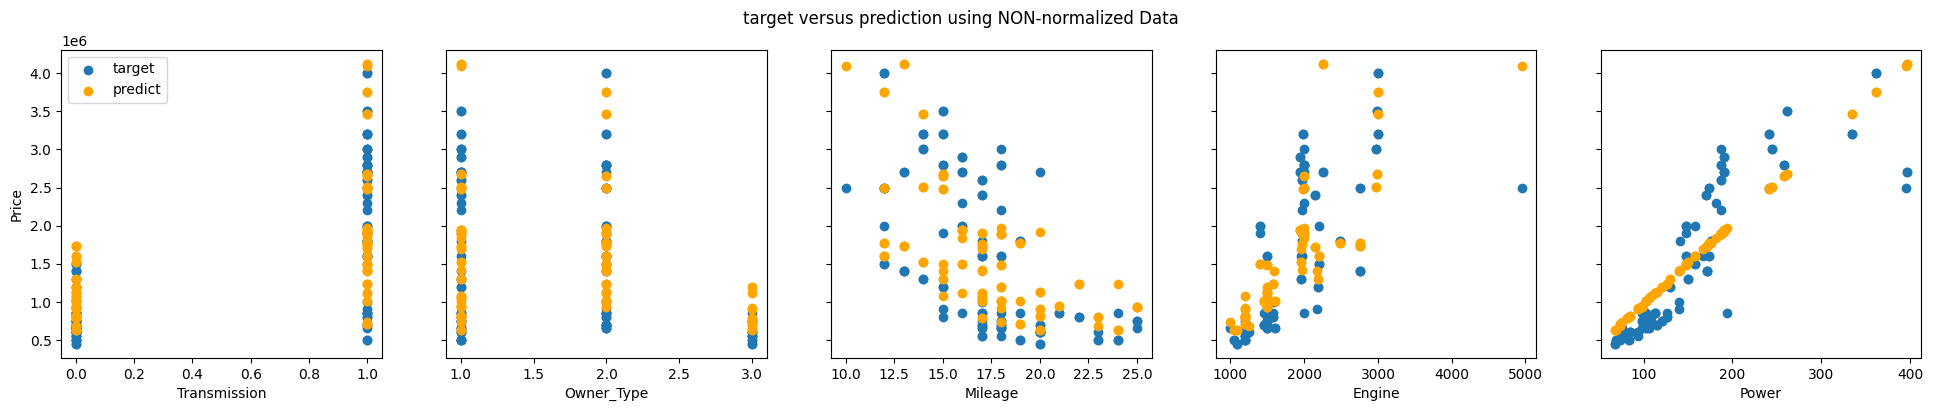

In [149]:
m = X.shape[0]

#predict target
yp_test = np.zeros(m)
for i in range(m):
    yp_test[i] = np.dot(X.iloc[i], w_out_test) + b_out_test

# # plot predictions and targets versus original features    
# fig,ax=plt.subplots(1,1,figsize=(6, 3),sharey=True)
# ax.scatter(X.iloc[:,0],y, label = 'target')
# ax.set_xlabel("Power")
# ax.scatter(X_norm.iloc[:,0],yp_test ,color=["orange"], label = 'predict')
# ax.set_ylabel("Price"); 
# ax.legend()
# fig.suptitle("target versus prediction using z-score normalized model")
# plt.show()

# plot predictions and targets versus original features for normalized data
fig,ax=plt.subplots(1,5,figsize=(24, 4),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X.iloc[:,i], y, label = 'target')
    ax[i].set_xlabel(X.columns[i])
    ax[i].scatter(X.iloc[:,i],yp_test,color=["orange"], label = 'predict')
ax[0].set_ylabel("Price"); 
ax[0].legend()
fig.suptitle("target versus prediction using NON-normalized Data")
plt.show()

In [150]:
X_norm_test , muX_test, sigmaX_test = zscore_normalize_features(X)
y_norm_test, muY_test , sigmaY_test = zscore_normalize_target(y)

w_out_norm_test, b_out_norm_test, hist_out_norm_test = gradient_descent(X_norm_test, y_norm_test, alpha=0.25, epochs=1000)

Iteration         0, Cost: 4.950e-01, weight: 0.000e+00, gradient: -6.697e-01
Iteration       100, Cost: 9.700e-02, weight: 2.917e-01, gradient: 1.488e-04
Iteration       200, Cost: 9.700e-02, weight: 2.908e-01, gradient: 1.911e-06
Iteration       300, Cost: 9.700e-02, weight: 2.908e-01, gradient: 2.478e-08
Iteration       400, Cost: 9.700e-02, weight: 2.908e-01, gradient: 3.215e-10
Iteration       500, Cost: 9.700e-02, weight: 2.908e-01, gradient: 4.170e-12
Iteration       600, Cost: 9.700e-02, weight: 2.908e-01, gradient: 5.401e-14
Iteration       700, Cost: 9.700e-02, weight: 2.908e-01, gradient: 6.661e-16
Iteration       800, Cost: 9.700e-02, weight: 2.908e-01, gradient: 9.104e-17
Iteration       900, Cost: 9.700e-02, weight: 2.908e-01, gradient: 1.033e-16


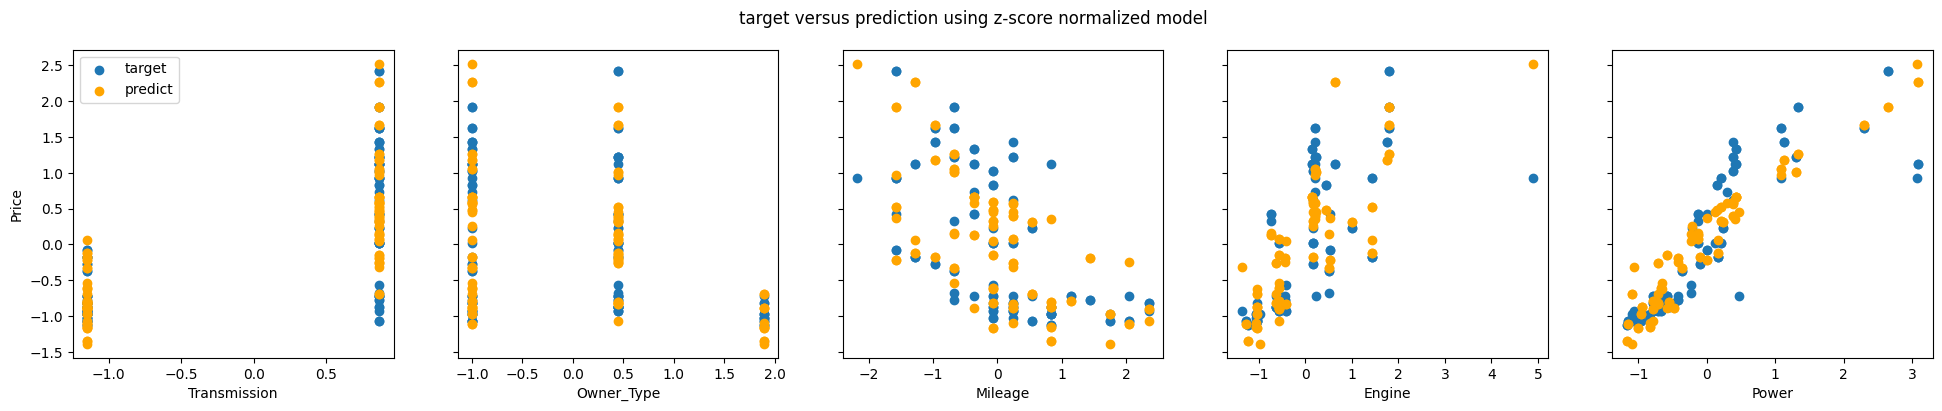

In [151]:
m = X_norm_test.shape[0]

#predict target
yp_norm_test = np.zeros(m)
for i in range(m):
    yp_norm_test[i] = np.dot(X_norm_test.iloc[i], w_out_norm_test) + b_out_norm_test

# # plot predictions and targets versus original features    
# fig,ax=plt.subplots(1,1,figsize=(6, 3),sharey=True)
# ax.scatter(X_norm_test.iloc[:,0],y_norm_test, label = 'target')
# ax.set_xlabel("Power")
# ax.scatter(X_norm_test.iloc[:,0],yp ,color=["orange"], label = 'predict')
# ax.set_ylabel("Price"); 
# ax.legend()
# fig.suptitle("target versus prediction using z-score normalized model")
# plt.show()

# plot predictions and targets versus original features for normalized data
fig,ax=plt.subplots(1,5,figsize=(24, 4),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_norm_test.iloc[:,i],y_norm_test, label = 'target')
    ax[i].set_xlabel(X_norm_test.columns[i])
    ax[i].scatter(X_norm_test.iloc[:,i],yp_norm_test,color=["orange"], label = 'predict')
ax[0].set_ylabel("Price"); 
ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [152]:
X_e_norm_test , mu_e_X_test, sigma_e_X_test = zscore_normalize_features(X_e)

w_out_e_test, b_out_e_test , hist_out_e_test = gradient_descent(X_e_norm_test, y_norm_test, alpha=0.25, epochs=10000)

Iteration         0, Cost: 4.950e-01, weight: 0.000e+00, gradient: -6.697e-01
Iteration      1000, Cost: 5.212e-02, weight: 5.792e-02, gradient: 5.228e-06
Iteration      2000, Cost: 5.056e-02, weight: 5.755e-02, gradient: 5.570e-07
Iteration      3000, Cost: 4.951e-02, weight: 5.743e-02, gradient: 4.529e-07
Iteration      4000, Cost: 4.879e-02, weight: 5.733e-02, gradient: 3.700e-07
Iteration      5000, Cost: 4.831e-02, weight: 5.724e-02, gradient: 3.010e-07
Iteration      6000, Cost: 4.798e-02, weight: 5.717e-02, gradient: 2.443e-07
Iteration      7000, Cost: 4.775e-02, weight: 5.712e-02, gradient: 1.979e-07
Iteration      8000, Cost: 4.760e-02, weight: 5.707e-02, gradient: 1.598e-07
Iteration      9000, Cost: 4.749e-02, weight: 5.704e-02, gradient: 1.286e-07


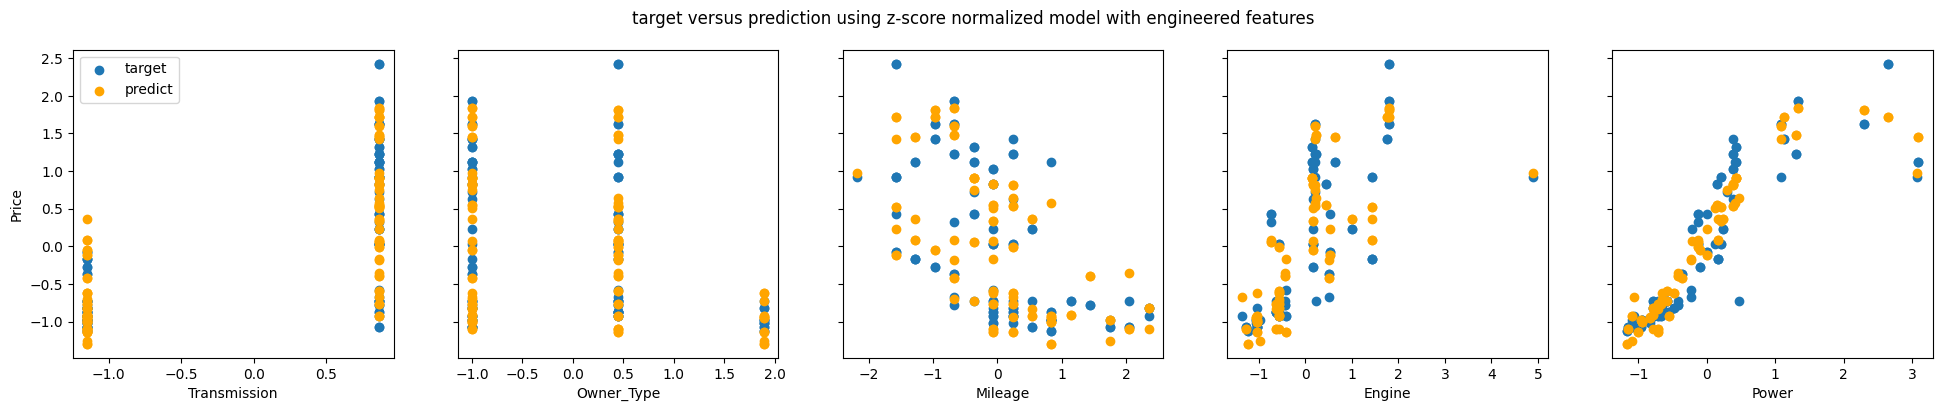

In [153]:
m = X_e_norm_test.shape[0]

# predict target
yp_e_norm_test = np.zeros(m)
for i in range(m):
    yp_e_norm_test[i] = np.dot(X_e_norm_test.iloc[i], w_out_e_test) + b_out_e_test

# plot predictions and targets versus original features for normalized data
fig,ax=plt.subplots(1,5,figsize=(24, 4),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_e_norm_test.iloc[:,i],y_norm_test, label = 'target')
    ax[i].set_xlabel(X_e_norm_test.columns[i])
    ax[i].scatter(X_e_norm_test.iloc[:,i],yp_e_norm_test,color=["orange"], label = 'predict')
ax[0].set_ylabel("Price"); 
ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model with engineered features")
plt.show()

### Creating Training Sets for Cross Validation

- We will create 5 different sets for cross-validation by making 5 folds.
- The Data used is the X_e data i.e. input data with engineered features to make the model a polynomial regression model

In [154]:
X_train_arr = list()
X_valid_arr = list()
y_train_arr = list()
y_valid_arr = list()

# Creates 5 different sets to be used for training and testing -> cross-validation
fold_size = int(X.shape[0]/5)
for i in range(0,5):
    X_valid_arr.append(X_e.iloc[i*fold_size: (i+1)*fold_size])
    X_train_arr.append(X_e.drop(X_e.index[i*fold_size: (i+1)*fold_size], inplace=False))
    y_valid_arr.append(y.iloc[i*fold_size: (i+1)*fold_size])
    y_train_arr.append(y.drop(y.index[i*fold_size: (i+1)*fold_size], inplace=False))

### Model Fitting

##### Apply Gradient Descent to each of the 5 training Sets to Find the Weights

In [155]:
n = X_train_arr[0].shape[1]
w_out_list = list()
b_out_list = list()
X_train_norm_list = list()
y_train_norm_list = list()
muY_list = list()
muX_list = list()
sigmaX_list = list()
sigma_y_list = list()

for i in range(0, len(X_train_arr)):
    X_train, muX, sigmaX = zscore_normalize_features(X_train_arr[i])
    y_train, muY, sigma_y = zscore_normalize_target(y_train_arr[i]) 
    w_out, b_out, hist_out = gradient_descent(X_train, y_train, alpha=0.25, epochs=10000, display=False)
    X_train_norm_list.append(X_train)
    y_train_norm_list.append(y_train)
    w_out_list.append(w_out)
    b_out_list.append(b_out)
    muX_list.append(muX)
    muY_list.append(muY)
    sigmaX_list.append(sigmaX)
    sigma_y_list.append(sigma_y)

##### Plot Best Fit Lines for Training Data

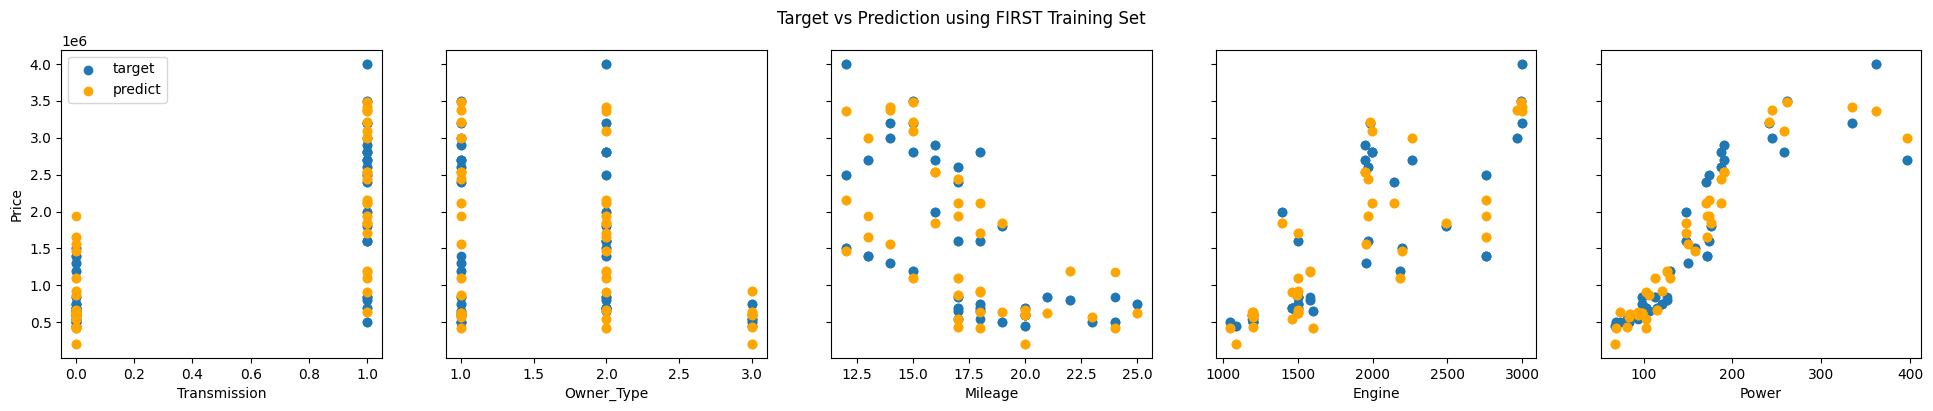

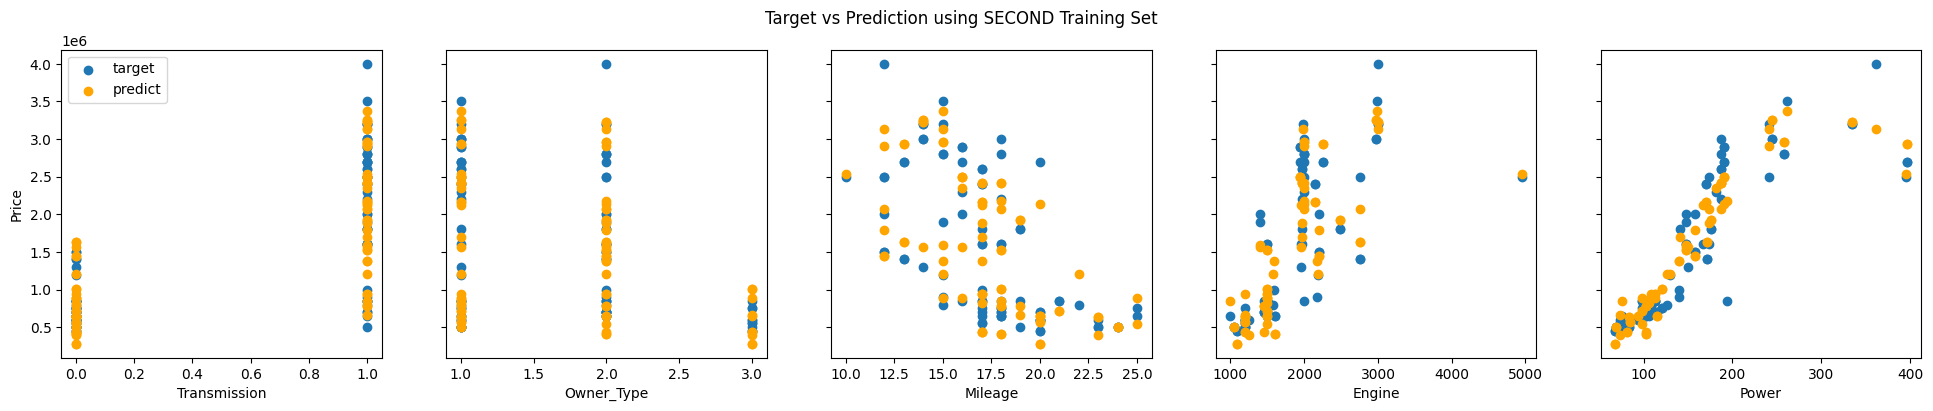

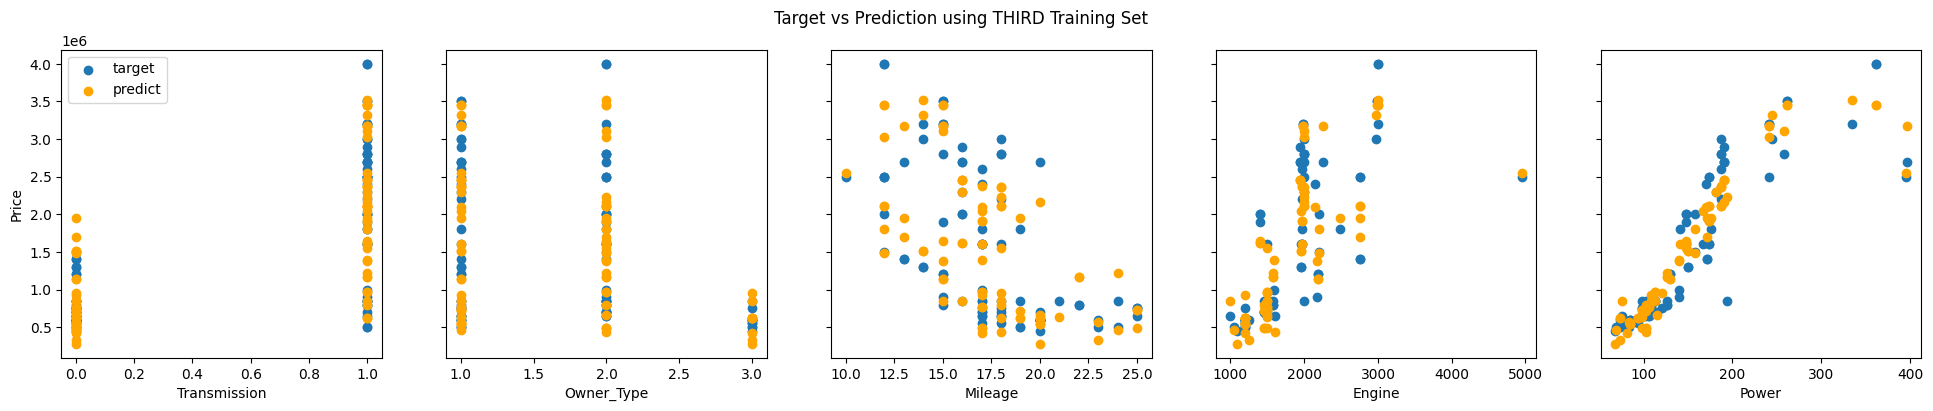

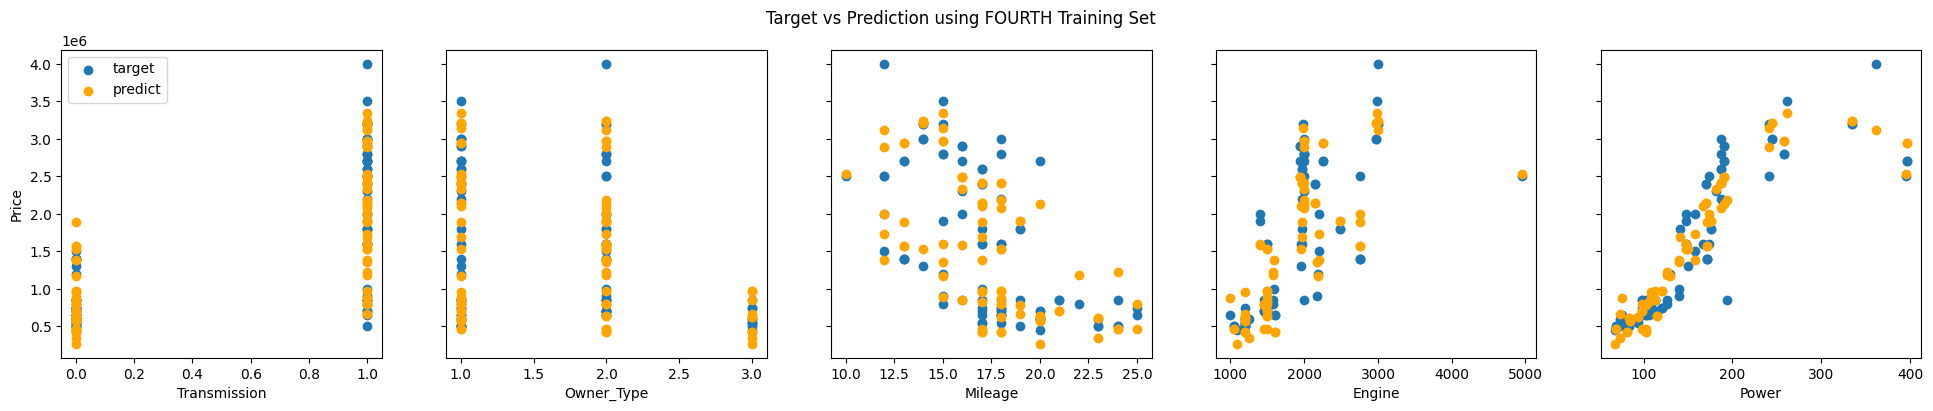

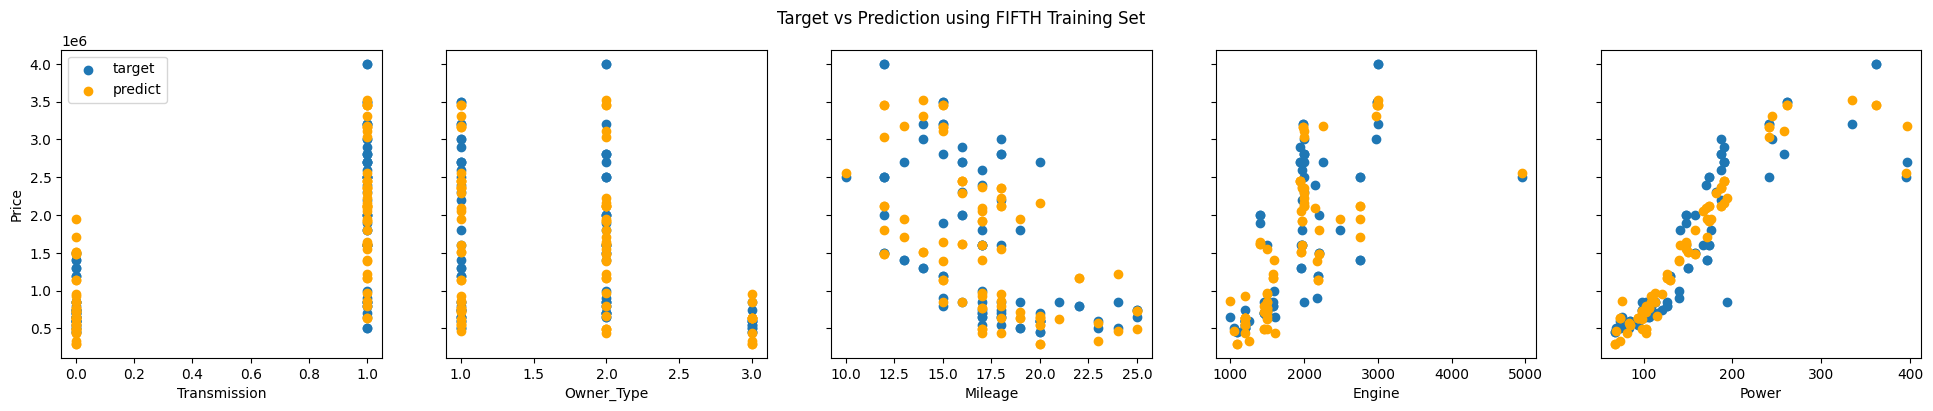

In [156]:
label = ['FIRST', 'SECOND', 'THIRD', 'FOURTH', 'FIFTH']
pd.set_option('display.max_rows', None)
yp_train_list = list()

for j in range(0, len(X_train_arr)):
    X_train_temp = X_train_norm_list[j]
    y_train_temp = y_train_norm_list[j]
    m = X_train.shape[0]    
    w_out = w_out_list[j]
    b_out = b_out_list[j]

    # predict target
    yp_train_temp = np.zeros(m)

    for i in range(m):
        yp_train_temp[i] = np.dot(X_train_temp.iloc[i], w_out) + b_out
    

    yp_train = (yp_train_temp * sigma_y_list[j]) + muY_list[j]
    y_train = (y_train_temp * sigma_y_list[j]) + muY_list[j]
    X_train = (X_train_temp * sigmaX_list[j]) + muX_list[j]
    
    # plot predictions and targets versus original features for normalized data
    fig,ax=plt.subplots(1,5,figsize=(24, 4),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter(X_train.iloc[:,i], y_train, label = 'target')
        ax[i].set_xlabel(X_train.columns[i])
        ax[i].scatter(X_train.iloc[:,i], yp_train,color=["orange"], label = 'predict')
    ax[0].set_ylabel("Price"); 
    ax[0].legend()
    fig.suptitle(f"Target vs Prediction using {label[j]} Training Set")
    plt.show()

### Model Validation

In [157]:
n = X_valid_arr[0].shape[1]
X_valid_norm_list = list()

# DO NOT run gradient descent here as we are using validation data to validate the model
for i in range(0, len(X_train_arr)):
    X_valid, muX, sigmaX = zscore_normalize_features(X_valid_arr[i])
    X_valid_norm_list.append(X_valid)

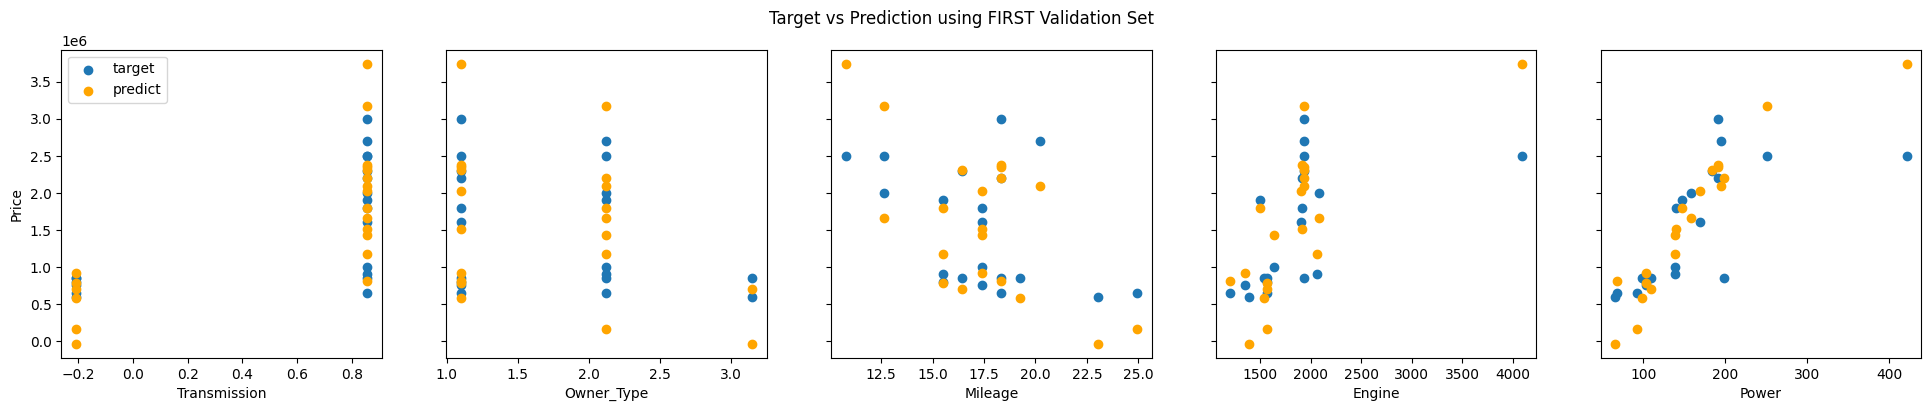

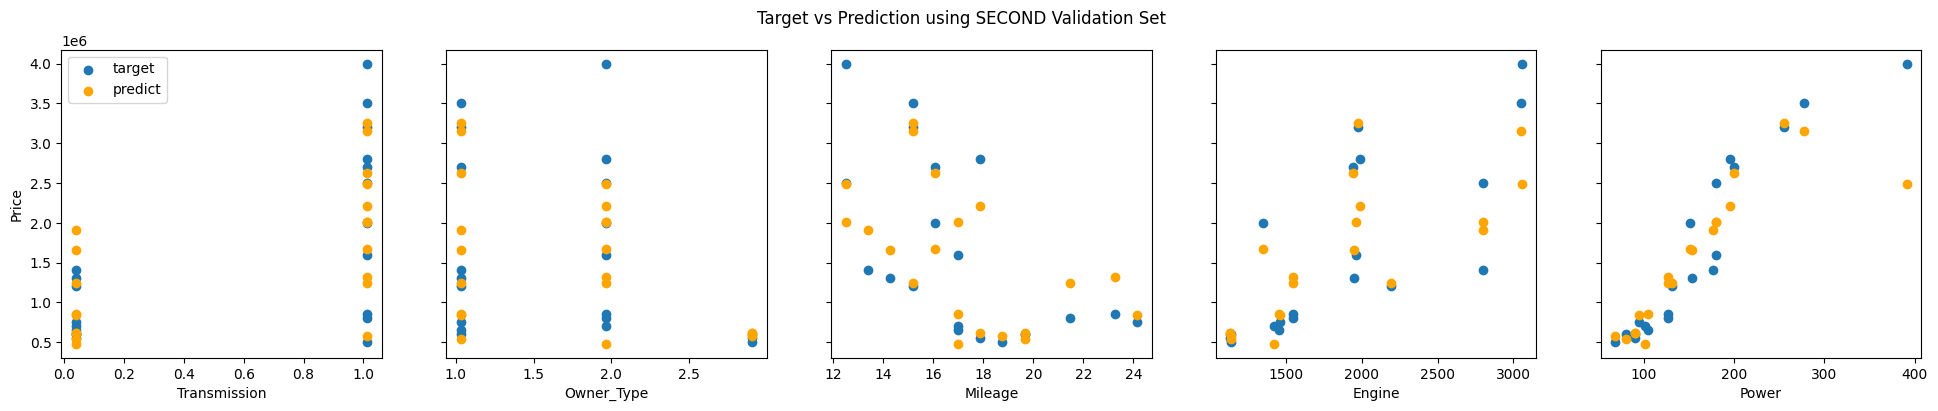

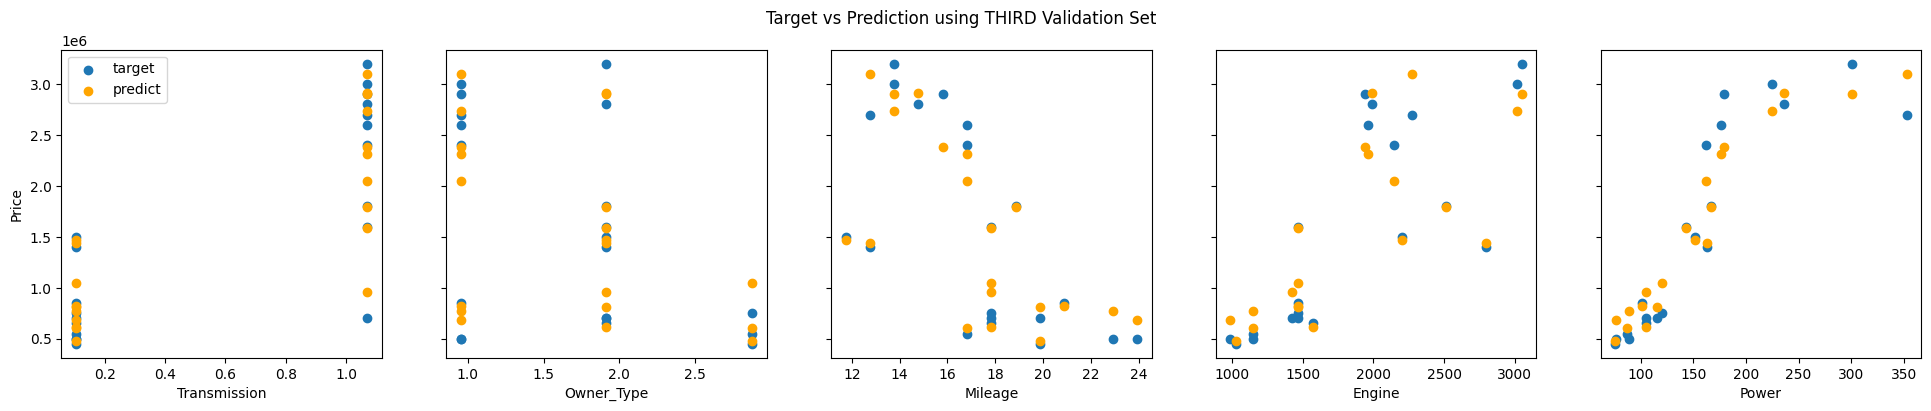

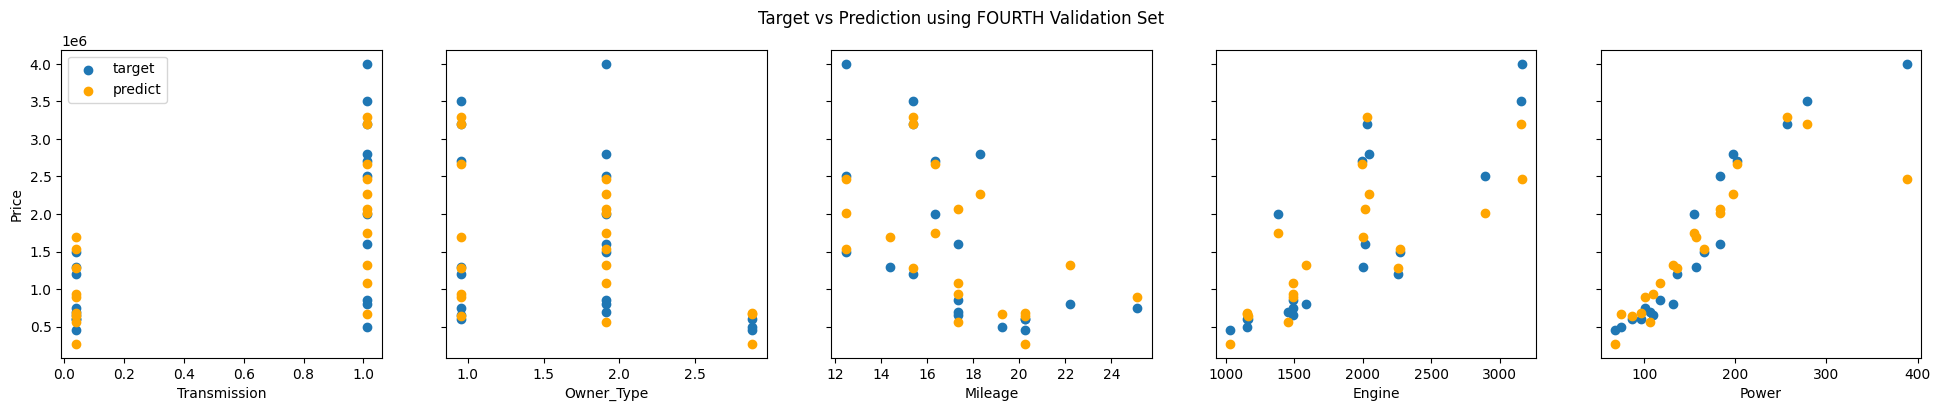

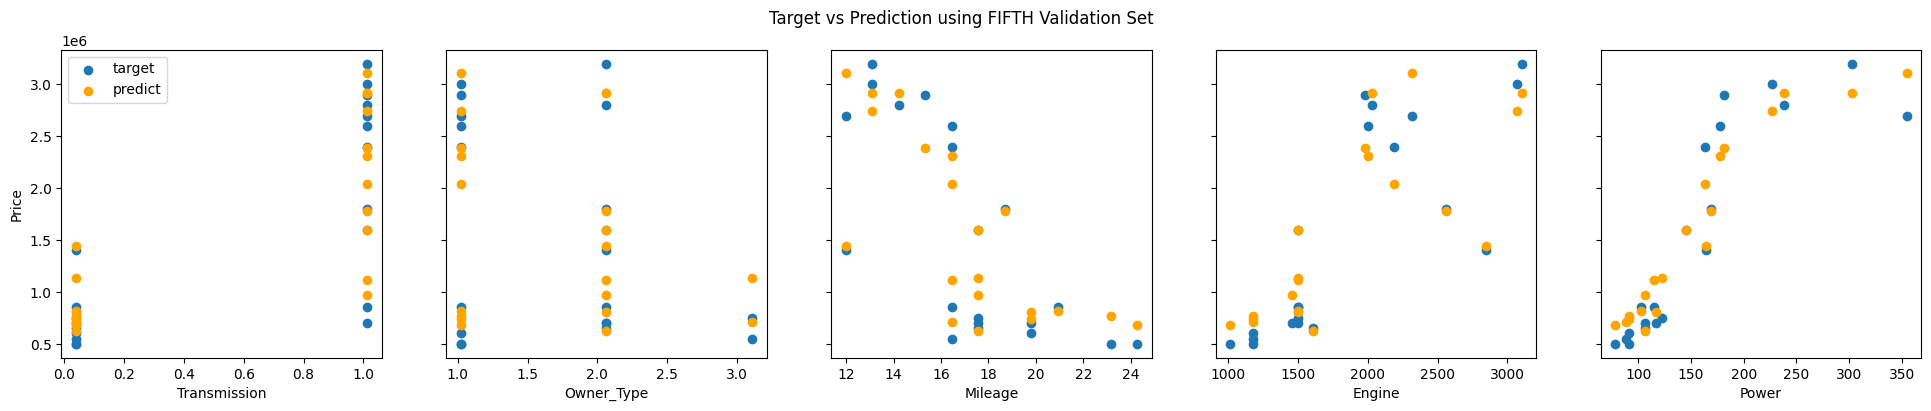

In [158]:
label = ['FIRST', 'SECOND', 'THIRD', 'FOURTH', 'FIFTH']
abs_errors_list = list()
percent_errors_list = list()

for j in range(0, len(X_valid_arr)):
    X_valid_temp = X_valid_norm_list[j]
    y_valid = y_valid_arr[j]
    m = X_valid.shape[0]    
    w_out = w_out_list[j]
    b_out = b_out_list[j]

    # predict target
    yp_valid_temp = np.zeros(m)

    for i in range(m):
        yp_valid_temp[i] = np.dot(X_valid_temp.iloc[i], w_out) + b_out

    yp_valid = (yp_valid_temp * sigma_y_list[j]) + muY_list[j]
    X_valid = (X_valid_temp * sigmaX_list[j]) + muX_list[j]

    abs_diff = abs(yp_valid - y_valid)
    percent_diff = abs((yp_valid - y_valid)/y_valid)*100
    abs_errors_list.append(abs_diff)
    percent_errors_list.append(percent_diff)
 
    # plot predictions and targets versus original features for normalized data
    fig,ax=plt.subplots(1,5,figsize=(24, 4),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter(X_valid.iloc[:,i], y_valid, label = 'target')
        ax[i].set_xlabel(X_valid.columns[i])
        ax[i].scatter(X_valid.iloc[:,i], yp_valid,color=["orange"], label = 'predict')
    ax[0].set_ylabel("Price"); 
    ax[0].legend()
    fig.suptitle(f"Target vs Prediction using {label[j]} Validation Set")
    plt.show()

abs_error = pd.concat(abs_errors_list, names="abs_error")
percent_error = pd.concat(percent_errors_list)
errors = pd.concat([abs_error, percent_error], axis=1, keys=["abs_error", "% error"])

### Errors and Analysis of Results

In [159]:
pd.options.display.float_format = "{:,.2f}".format
errors.describe()

,abs_error,% error
count,100.00,100.00
mean,"285,025.68",22.37
std,"291,520.44",22.97
min,629.40,0.04
25%,"79,084.64",7.55
50%,"255,348.68",16.60
75%,"394,652.49",31.04
max,"1,531,269.22",158.37


In [160]:
errors.head()

,abs_error,% error
Car_ID,,
1,"22,181.43",2.77
2,"436,138.88",43.61
3,"1,242,218.90",49.69
4,"637,216.17",106.20
5,"1,346,122.86",158.37


##### Results
1. The number of data points used in validation = 100, i.e. 5 validation sets with 20 data points each.
2. The mean percent error in the prediction over 5 cross-validation sets is about +/- 22% which corresponds to an absolute error of 2,85,025
3. The first quartile of predictions have a percent error of less than 8%
4. The median precent error in predicition is 16.6% which means 50 datapoints have a predicted price with an error less than 16.6%
5. The third quartile of predicitions have a percent error between 16.6% and 31%
6. The max error is 158%, and the last quartile has an error between 31% and 158%  

##### Results Analysis
1. There are only 100 datapoints in the given data, this made it a little harder for the training model to learn more precise relationships between features and output
2. Further, we have selected 5 different features that the model has to use, since all 5 features have a an impact on price, the polynomial model of third order was not able to fit all the data 
3. The first quartile of the predicitions were accuarate enough, however the last quartile of predicitions were highly inaccurate, which can be attributed to the above 2 points


### Project Analysis

##### Learnings
1. The main learnings of this project were understanding and implementing the underlying functions of Cost function, Gradient Descent , Prediction Model , Feature Scaling, Model Fitting, Model Validation and Cross-Validation from scratch using only basic Python and minimal libraries which helped me strengthen my core ML (and consequently DL) concepts.
2. Got hands-on with the process of Data Cleaning and Pre-Processing for model usage
3. Visualize the difference between many alternatives:
    - Time Taken by Vector Dot Product vs Matrix Operations vs Loop
    - Gradient Descent with Normalized features vs Unnormalized features
    - Model fitting with Linear Regression model vs Polynomial Regression Model
4. Basic Plotting with Matplotlib

##### Future Scope
1. Add more graphs for visualization of gradient descent, feature scaling, etc.
2. Create a model that uses standard libraries like sci-kit learn and compare the difference in accuracy
3. Adding regularization 
4. Feature Engineering - PCA (principal component analysis)

### Applying Regularization